In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.example_libraries import stax, optimizers
import matplotlib.pyplot as plt
import pinns 
import datetime
import jax.scipy.optimize
import jax.flatten_util
import scipy
import scipy.optimize
from jax.config import config
config.update("jax_enable_x64", True)
rnd_key = jax.random.PRNGKey(1234)

In [2]:

def create_geometry(key, scale = 1):
    scale = scale
    Nt = 24                                                                
    lz = 40e-3                                                             
    Do = 72e-3                                                            
    Di = 51e-3                                                            
    hi = 13e-3                                                             
    bli = 3e-3                                                             
    Dc = 3.27640e-2                                                           
    hc = 7.55176e-3                                                           
    ri = 20e-3                                                           
    ra = 18e-3                                                           
    blc = hi-hc                                                           
    rm = (Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri)                 
    R = rm-ri
    O = np.array([rm/np.sqrt(2),rm/np.sqrt(2)])
    alpha1 = -np.pi*3/4       
    alpha2 = np.math.asin((hc-rm/np.sqrt(2))/R)
    alpha = np.abs(alpha2-alpha1)
    
    A = np.array([[O[0] - ri/np.sqrt(2), O[1] - ri/np.sqrt(2)], [O[0] - Dc, O[1] - hc]])
    b = np.array([[A[0,0]*ri/np.sqrt(2)+A[0,1]*ri/np.sqrt(2)],[A[1,0]*Dc+A[1,1]*hc]])
    C = np.linalg.solve(A,b)
    
    knots1 = np.array([[Do,Do * np.tan(np.pi/8)],[Do/np.sqrt(2),Do/np.sqrt(2)],[rm/np.sqrt(2),rm/np.sqrt(2)],[ri/np.sqrt(2),ri/np.sqrt(2)]])
    #knots2 = np.array([[Dc,hc],[Dc+blc,hi],[Di-bli,hi],[Di,hi-bli],[Di,0]])
    knots2 = np.array([[Di,hi-bli],[Di-bli,hi],[Dc+blc,hi],[Dc,hc]])
    knots3 = (knots1+knots2)/2
    knots3[-1,:] = C.flatten()
    knots = np.concatenate((knots1[None,...],knots3[None,...],knots2[None,...]),0)
    weights = np.ones(knots.shape[:2])
    weights[1,-1] = np.sin((np.pi-alpha)/2)
    basis2 = pinns.bspline.BSplineBasis(np.linspace(0,1,4),1)
    basis1 = pinns.bspline.BSplineBasis(np.array([0,1]),2)

    geom1 = pinns.geometry.PatchNURBS([basis1, basis2], knots, weights, key)
   
    knots2 = np.array([ [ [Dc,0],[Dc+blc,0],[Di-bli,0],[Di,0] ] , [[Dc,hc],[Dc+blc,hi],[Di-bli,hi],[Di,hi-bli]] ]) 
    knots2 = knots2[:,::-1,:]
    weights = np.ones(knots2.shape[:2])
    
    basis1 = pinns.bspline.BSplineBasis(np.linspace(0,1,2),1)
    basis2 = pinns.bspline.BSplineBasis(np.array([0,0.2,0.8,1]),1)

    geom2 = pinns.geometry.PatchNURBS([basis1, basis2], knots2, weights, key)
   
    knots = np.array([ [ [0,0] , [Dc/2,0] , [Dc,0] ] , [ [ri/np.sqrt(2),ri/np.sqrt(2)] , [C[0,0],C[1,0]] , [Dc,hc] ]])
    
    basis1 = pinns.bspline.BSplineBasis(np.linspace(0,1,2),1)
    basis2 = pinns.bspline.BSplineBasis(np.array([0,1]),2)
    
    weights = np.ones(knots.shape[:2])
    weights[1,1] = np.sin((np.pi-alpha)/2)
    geom3 = pinns.geometry.PatchNURBS([basis1, basis2], knots, weights, key)
     
    return  geom1, geom3, geom2

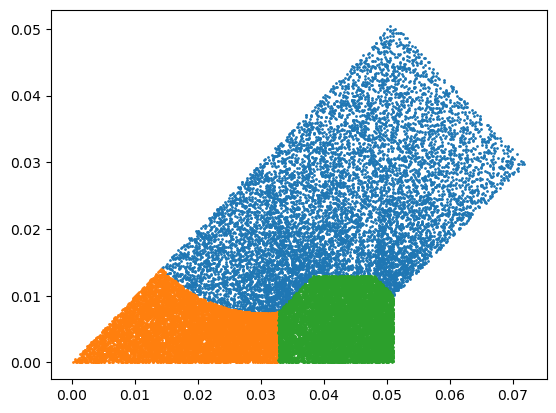

In [3]:
geom1, geom2, geom3 = create_geometry(rnd_key)

pts = geom1.sample_inside(10000)

plt.figure()
plt.scatter(pts[:,0], pts[:,1], s = 1)

pts = geom2.sample_inside(10000)
plt.scatter(pts[:,0],pts[:,1], s = 1)

pts = geom3.sample_inside(10000)
plt.scatter(pts[:,0],pts[:,1], s = 1)
plt.show()

In [4]:

def interface_function2d(nd, endpositive, endzero, nn):

    faux = lambda x: ((x-endzero)**2/(endpositive-endzero)**2)
    if nd == 0:
        fret = lambda ws, x: (nn(ws, x[...,1][...,None]).flatten()*faux(x[...,0]))[...,None]
    else:
        fret = lambda ws, x: (nn(ws, x[...,0][...,None]).flatten()*faux(x[...,1]))[...,None]
    return fret

class Model(pinns.PINN):
    def __init__(self, rand_key):
        super().__init__()
        self.key = rand_key

        N = [64,128]
        nl = 4
        
        block = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl), stax.Tanh, stax.Dense(nl), stax.Tanh),stax.Dense(nl)),stax.FanInSum)
    
        self.add_neural_network('u1',stax.serial(block,block,block,block,block,stax.Dense(1)),(-1,2)) # iron
        self.add_neural_network('u2',stax.serial(block,block,block,block,block,stax.Dense(1)),(-1,2)) # air 
        self.add_neural_network('u3',stax.serial(block,block,block,block,block,stax.Dense(1)),(-1,2)) # copper
        self.add_neural_network('u12',stax.serial(stax.Dense(nl),stax.Tanh,stax.Dense(nl),stax.Tanh,stax.Dense(1)),(-1,1))
        self.add_neural_network('u13',stax.serial(stax.Dense(nl),stax.Tanh,stax.Dense(nl),stax.Tanh,stax.Dense(1)),(-1,1))
        self.add_neural_network('u23',stax.serial(stax.Dense(nl),stax.Tanh,stax.Dense(nl),stax.Tanh,stax.Dense(1)),(-1,1))
        

        self.init_points(N)
        
        self.interface12 = interface_function2d(0,1.0,0.0,self.neural_networks['u12'])
        self.interface21 = interface_function2d(1,1.0,0.0,self.neural_networks['u12'])
        self.interface23 = interface_function2d(1,1.0,0.0,self.neural_networks['u23'])
        self.interface32 = interface_function2d(1,1.0,0.0,self.neural_networks['u23'])
        self.interface13 = interface_function2d(0,1.0,0.0,self.neural_networks['u13'])
        self.interface31 = interface_function2d(0,1.0,0.0,self.neural_networks['u13'])
        self.eps1 = 1/6
        self.eps2 = 1/2
        
    def init_points(self, N):
        
        Knots = np.meshgrid(np.polynomial.legendre.leggauss(N[0])[0]*0.5+0.5, np.polynomial.legendre.leggauss(N[1])[0]*0.5+0.5)
        ys = np.concatenate(tuple([k.flatten()[:,None] for k in Knots]),-1)
        Weights = np.kron(np.polynomial.legendre.leggauss(N[0])[1]*0.5, np.polynomial.legendre.leggauss(N[1])[1]*0.5)
        # ys = np.random.rand(5000,2)*2-1
        # Weights = np.ones((5000))/5000*4
        
        self.points = { 'ys' : ys , 'ws' : Weights}
        DGys = geom1._eval_omega(ys)
        Inv = np.linalg.inv(DGys)
        det = np.abs(np.linalg.det(DGys))
        self.points['K1'] = np.einsum('mij,mjk,m->mik',Inv,np.transpose(Inv,[0,2,1]),det)
        self.points['omega1'] = det
       
        DGys = geom2._eval_omega(ys)
        Inv = np.linalg.inv(DGys)
        det = np.abs(np.linalg.det(DGys))
        self.points['K2'] = np.einsum('mij,mjk,m->mik',Inv,np.transpose(Inv,[0,2,1]),det)
        self.points['omega2'] = det
        
        
    def solution1(self, ws, x):
        # iron
        u = self.neural_networks['u1'](ws['u1'],x)
        v = ((x[...,0] - 1)*(x[...,0] + 0)*(x[...,1] - 1)*(x[...,1]+0))[...,None]
        w =  self.interface12(ws['u12'],x)*(x[...,0] - 1)[...,None]*(x[...,0] + 0)[...,None] + self.interface13(ws['u13'],x)*(x[...,1] - 1)[...,None]*(x[...,1] + 0)[...,None]
        return u*v+w
    
    def solution2(self, ws, x):
        
        u = self.neural_networks['u2'](ws['u2'],x)
        v = ((x[...,1] - 1)*(x[...,1] + 0)*(x[...,0] -1))[...,None]
        w = self.interface21(ws['u12'],x)*(x[...,1] - 1)[...,None]*(x[...,1] + 0)[...,None] + self.interface23(ws['u23'],x)*(x[...,0] - 1)[...,None]*(x[...,0] + 0)[...,None]
        return u*v+w
    
    def solution3(self, ws, x):
        
        u = self.neural_networks['u1'](ws['u3'],x)*0
        v = ((x[...,1] - 1)*(x[...,1] + 0)*(x[...,0]-1))[...,None]
        w =  self.interface32(ws['u23'],x)*(x[...,0] - 1)[...,None]*(x[...,0] + 0)[...,None]+self.interface31(ws['u13'],x)*(x[...,1] - 1)[...,None]*(x[...,1] + 0)[...,None]
        return u*v + w
        
    def loss_pde(self, ws):
        grad1 = pinns.operators.gradient(lambda x : self.solution1(ws,x))(self.points['ys'])[...,0,:]
        grad2 = pinns.operators.gradient(lambda x : self.solution2(ws,x))(self.points['ys'])[...,0,:]
        
        
        
        lpde1 = 0.5*self.eps1*jnp.dot(jnp.einsum('mi,mij,mj->m',grad1,self.points['K1'],grad1), self.points['ws'])  
        lpde2 = 0.5*self.eps2*jnp.dot(jnp.einsum('mi,mij,mj->m',grad2,self.points['K2'],grad2), self.points['ws'])  
        return lpde1+lpde2

    def loss(self, ws):
        lpde = self.loss_pde(ws)
        return lpde
    


In [5]:
rnd_key = jax.random.PRNGKey(123)
model = Model(rnd_key)
w0 = model.init_unravel()
weights = model.weights 

x,y = np.meshgrid(np.linspace(0,1,100),np.linspace(0,1,100))
ys = np.concatenate((x.flatten()[:,None],y.flatten()[:,None]),1)
xy1 = geom1(ys)
xy2 = geom2(ys)
xy3 = geom3(ys)

u1 = model.solution1(weights, ys).reshape(x.shape)
u2 = model.solution2(weights, ys).reshape(x.shape)
u3 = model.solution3(weights, ys).reshape(x.shape)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_surface(xy1[:,0].reshape(x.shape), xy1[:,1].reshape(x.shape), u1, cmap ='viridis', vmin = min([u1.min(),u2.min(),u3.min()]), vmax = max([u1.max(),u2.max(),u3.max()]), edgecolor =None)
ax.plot_surface(xy2[:,0].reshape(x.shape), xy2[:,1].reshape(x.shape), u2, cmap ='viridis', vmin = min([u1.min(),u2.min(),u3.min()]), vmax = max([u1.max(),u2.max(),u3.max()]), edgecolor =None)
ax.plot_surface(xy3[:,0].reshape(x.shape), xy3[:,1].reshape(x.shape), u3, cmap ='viridis', vmin = min([u1.min(),u2.min(),u3.min()]), vmax = max([u1.max(),u2.max(),u3.max()]), edgecolor =None)
ax.view_init(90,0)
plt.show()

plt.figure()
plt.contourf(xy1[:,0].reshape(x.shape), xy1[:,1].reshape(x.shape), u1, cmap ='viridis', vmin = min([u1.min(),u2.min(),u3.min()]), vmax = max([u1.max(),u2.max(),u3.max()]), levels=64)
plt.contourf(xy2[:,0].reshape(x.shape), xy2[:,1].reshape(x.shape), u2, cmap ='viridis', vmin = min([u1.min(),u2.min(),u3.min()]), vmax = max([u1.max(),u2.max(),u3.max()]), levels=64)
plt.contourf(xy3[:,0].reshape(x.shape), xy3[:,1].reshape(x.shape), u3, cmap ='viridis', vmin = min([u1.min(),u2.min(),u3.min()]), vmax = max([u1.max(),u2.max(),u3.max()]), levels=64)
plt.colorbar()

x1,_ = geom2[0,:].importance_sampling(1000)
x2,_ = geom2[:,0].importance_sampling(1000)
x3,_ = geom2[1,:].importance_sampling(1000)
x4,_ = geom2[:,1].importance_sampling(1000)


plt.figure()
plt.scatter(x1[:,0],x1[:,1],s=1,c='k')
plt.scatter(x2[:,0],x2[:,1],s=1,c='k')
plt.scatter(x3[:,0],x3[:,1],s=1,c='k')
plt.scatter(x4[:,0],x4[:,1],s=1,c='k')
plt.text(geom2(np.array([[0,0]]))[0,0],geom2(np.array([[0,0]]))[0,1],"(0,0)")
plt.text(geom2(np.array([[0,1]]))[0,0],geom2(np.array([[0,1]]))[0,1],"(0,1)")
plt.text(geom2(np.array([[1,0]]))[0,0],geom2(np.array([[1,0]]))[0,1],"(1,0)")
plt.text(geom2(np.array([[1,1]]))[0,0],geom2(np.array([[1,1]]))[0,1],"(1,1)")

x1,_ = geom1[0,:].importance_sampling(1000)
x2,_ = geom1[:,0].importance_sampling(1000)
x3,_ = geom1[1,:].importance_sampling(1000)
x4,_ = geom1[:,1].importance_sampling(1000)

plt.text(geom1(np.array([[0,0]]))[0,0],geom1(np.array([[0,0]]))[0,1],"(0,0)")
plt.text(geom1(np.array([[0,1]]))[0,0],geom1(np.array([[0,1]]))[0,1],"(0,1)")
plt.text(geom1(np.array([[1,0]]))[0,0],geom1(np.array([[1,0]]))[0,1],"(1,0)")
plt.text(geom1(np.array([[1,1]]))[0,0],geom1(np.array([[1,1]]))[0,1],"(1,1)")
plt.show()

x1,_ = geom3[0,:].importance_sampling(1000)
x2,_ = geom3[:,0].importance_sampling(1000)
x3,_ = geom3[1,:].importance_sampling(1000)
x4,_ = geom3[:,1].importance_sampling(1000)

plt.figure()
plt.scatter(x1[:,0],x1[:,1],s=1,c='k')
plt.scatter(x2[:,0],x2[:,1],s=1,c='k')
plt.scatter(x3[:,0],x3[:,1],s=1,c='k')
plt.scatter(x4[:,0],x4[:,1],s=1,c='k')
plt.text(geom3(np.array([[0,0]]))[0,0],geom3(np.array([[0,0]]))[0,1],"(0,0)")
plt.text(geom3(np.array([[0,1]]))[0,0],geom3(np.array([[0,1]]))[0,1],"(0,1)")
plt.text(geom3(np.array([[1,0]]))[0,0],geom3(np.array([[1,0]]))[0,1],"(1,0)")
plt.text(geom3(np.array([[1,1]]))[0,0],geom3(np.array([[1,1]]))[0,1],"(1,1)")
plt.show()

2022-10-22 09:50:23.078629: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:219] failed to create cublas handle: cublas error
2022-10-22 09:50:23.079280: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:221] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2022-10-22 09:50:23.079359: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2153] Execution of replica 0 failed: INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


XlaRuntimeError: INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support